In [3]:
%pip install torchbnn


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [5]:
# def torch_train_test_timesplit(*tensors, start_idx=None, split=.8, size=1000):
#     # if start_idx is None, generate random start
#     train_size = int(split * size) if isinstance(split, float) else split
#     test_size = size - train_size

#     data_tensors = list()
#     for tensor in tensors:
#         start_idx = torch.randint(0, tensor.shape[0] - size, 1) if start_idx is None else start_idx
#         assert start_idx < tensor.shape[0] - size, f'Start index {start_idx} is too large for size {tensor.shape[0]} tensor with full size of {size}'
#         train_indices = torch.linspace(start_idx, train_size + start_idx, train_size)
#         test_indices = torch.linspace(train_size + start_idx, test_size + train_size + start_idx, test_size)
#         train_data = tensor[train_indices]
#         test_data = tensor[test_indices]
#         data_tensors.extend((train_data, test_data))
#     return data_tensors
   
class TorchTimesplitDataset(Dataset):
    def __init__(self, signal_tensor, split=990, size=1000):
        if signal_tensor.dim() == 2:
            assert signal_tensor.shape[1] == 1
            self._signal = signal_tensor
        elif signal_tensor.dim() == 1:
            self._signal = signal_tensor.unsqueeze(dim=-1)
        else:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape of 1')
        self.train_size = int(split * size) if isinstance(split, float) else split
        self.test_size = size - self.train_size
        self._size = size
        return
    
    @property
    def shape(self):
        return self._signal.shape[0] - self._size, 1

    def __len__(self):
        return self._signal.shape[0] - self._size

    def __getitem__(self, index):
        in_indices = torch.linspace(start_idx, train_size + start_idx, train_size, dtype=torch.int)
        forward_indices = torch.linspace(train_size + start_idx, test_size + train_size + start_idx, test_size, dtype=torch.int)
        in_sample_data = self._signal[in_indices]
        forward_sample_data = self._signal[forward_indices]
        return in_sample_data, forward_sample_data

(10000,)


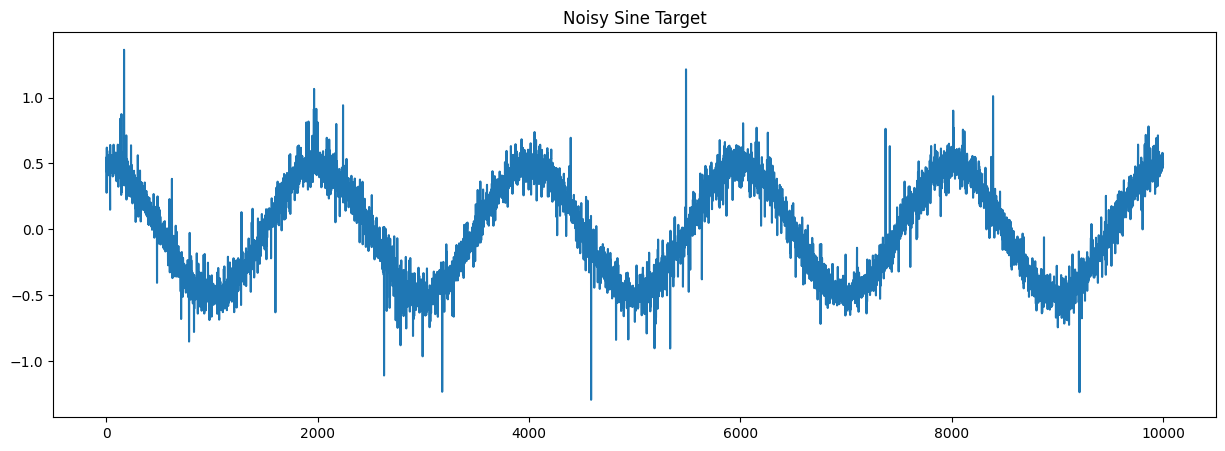

In [11]:
large_wave = WaveGen(size=10_000).linear_phase().cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
print(large_wave.shape)
plt.figure(figsize=(15,5))
plt.plot(large_wave)
plt.title('Noisy Sine Target')
plt.show()

In [4]:
dataset = TorchTimesplitDataset(large_wave)

In [5]:
# https://jamesmccaffrey.wordpress.com/2021/08/30/an-example-of-a-bayesian-neural-network-using-pytorch/bayesian_neural_network_demo/
class SineBayesianRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, prior_mu=0, prior_sigma=.1):
        super(SineBayesianRegressor, self).__init__()
        self.input = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_size, out_features=hidden_size)
        self.output = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_size, out_features=output_size)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = torch.relu(x)
        x = self.output(x)
        return x

In [6]:
def train(
    model, 
    dataset,
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        for train_sample, test_sample in dataloader:
            optimizer.zero_grad()
            sample = model(train_sample)
            
            loss = criterion(sample, test_sample)       
            loss.backward()
            optimizer.step()

#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)

#             if p and not epoch % 10:
#                 print('Train Loss', train_loss.item())
#                 print('Test Loss', test_loss.item())
#                 p = False
                
#         if test_full:
#             train_original, train_denoised = train_dataset[:]
#             test_original, test_denoised = test_dataset[:]
#             train_output = model(train_original)
#             train_loss = criterion(train_output, train_denoised)
#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)
#             if early_stop_patience:
#                 if test_loss > loss_buffer:
#                     patience += 1
#                     if patience >= early_stop_patience:
#                         items = items[:-early_stop_patience]
#                         model = model_buffer
#                         break
#                 else:
#                     model_buffer = model
#                     loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append(loss.item())
    return model, items

def plot_loss(loss, title='', step=1):
    plt.figure(figsize=(16,8))
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(loss[::step], dashes=False, color=colors[0], label='Train MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
input_sizes = [700,800,900]
sizes = [950,1000,1100]
hidden_sizes = [64, 128, 256, 512, 2048]

columns = ['input_size','output_size','hidden_size','loss']
rows = list()
n_epochs = 30
batch_size = 32
for i, (input_size, size, hidden_size) in enumerate(itertools.product(input_sizes, sizes, hidden_sizes)):
    if size <= input_size: continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(input_size, size, hidden_size, sep='|')
    output_size = size - input_size
    
    model = SineDAE(
        input_size, 
        output_size, 
        hidden_size, 
        prior_mu=0, 
        prior_sigma=.1,
    ).double()
    
    try:
        model, loss = train(
            model, 
            dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(loss):
        print('Missing loss')
        continue
    rows.append((input_size, output_size, hidden_size, loss[-1]))

Input Set 1 out of 300
1|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))
Input Set 2 out of 300
1|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 3 out of 300
1|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 4 out of 300
1|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 5 out of 300
1|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x250). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 26 out of 300
1|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))
Input Set 27 out of 300
1|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Input Set 28 out of 300
1|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 29 out of 300
1|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 30 out of 300
1|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 51 out of 300
1|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x249). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 52 out of 300
1|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 53 out of 300
1|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 54 out of 300
1|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 55 out of 300
1|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 76 out of 300
1|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Missing loss
Input Set 77 out of 300
1|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 78 out of 300
1|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 79 out of 300
1|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 80 out of 300
1|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 81 out of 300
1|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x243). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 82 out of 300
1|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 83 out of 300
1|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 84 out of 300
1|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 85 out of 300
1|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 87 out of 300
1|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 88 out of 300
1|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 89 out of 300
1|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 90 out of 300
1|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 101 out of 300
2|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x61). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x31). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 102 out of 300
2|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))
Input Set 103 out of 300
2|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 104 out of 300
2|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 105 out of 300
2|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))
Input Set 126 out of 300
2|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x250). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 127 out of 300
2|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Input Set 128 out of 300
2|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 129 out of 300
2|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 130 out of 300
2|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 151 out of 300
2|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x249). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 152 out of 300
2|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Input Set 153 out of 300
2|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 154 out of 300
2|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 155 out of 300
2|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 176 out of 300
2|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Input Set 177 out of 300
2|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 178 out of 300
2|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 179 out of 300
2|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 180 out of 300
2|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 181 out of 300
2|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x243). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 182 out of 300
2|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 183 out of 300
2|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 184 out of 300
2|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 185 out of 300
2|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 187 out of 300
2|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 188 out of 300
2|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 189 out of 300
2|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 190 out of 300
2|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 201 out of 300
4|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x61). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x31). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 202 out of 300
4|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))
Input Set 203 out of 300
4|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 204 out of 300
4|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 205 out of 300
4|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))
Input Set 226 out of 300
4|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x250). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 227 out of 300
4|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Missing loss
Input Set 228 out of 300
4|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Missing loss
Input Set 229 out of 300
4|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 230 out of 300
4|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 251 out of 300
4|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x249). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 252 out of 300
4|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Input Set 253 out of 300
4|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 254 out of 300
4|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 255 out of 300
4|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 276 out of 300
4|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Input Set 277 out of 300
4|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 278 out of 300
4|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 279 out of 300
4|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 280 out of 300
4|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 281 out of 300
4|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x243). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 282 out of 300
4|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 283 out of 300
4|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 284 out of 300
4|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 285 out of 300
4|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 287 out of 300
4|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 288 out of 300
4|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 289 out of 300
4|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 290 out of 300
4|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x61). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x31). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


In [8]:
grid_df = pd.DataFrame(rows, columns=columns)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,1,4,4,16,0.000357,0.000359
1,1,4,4,32,NaN,NaN
2,1,4,4,128,NaN,NaN
3,1,4,4,192,NaN,NaN
4,1,8,4,16,0.000356,0.000356
5,1,8,4,32,0.000169,0.000170
6,1,8,4,128,0.000387,0.000390
7,1,8,4,192,0.000064,0.000065
8,1,6,4,16,NaN,NaN
9,1,6,4,128,NaN,NaN


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


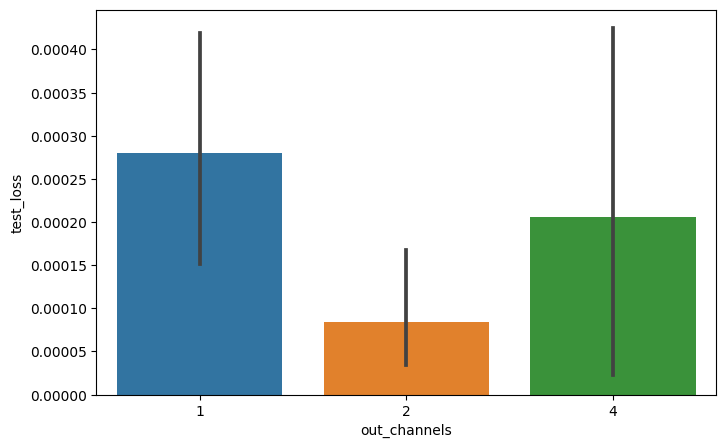

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


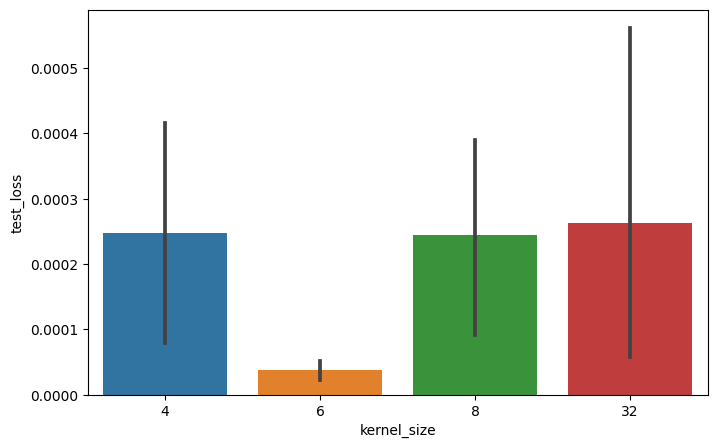

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


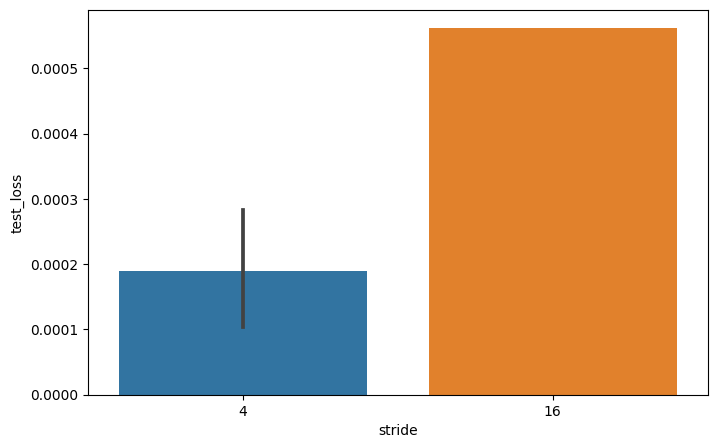

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


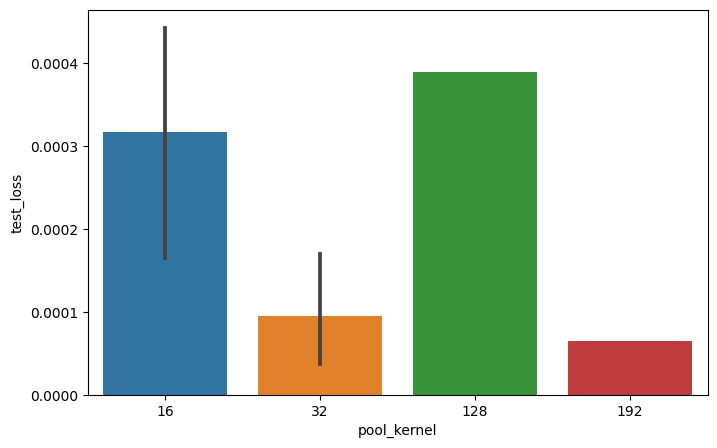

In [9]:
for col in columns[:-1]:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()